# 순환 신경망 분류 모델

## 랜덤 시드 고정

In [1]:
import tensorflow as tf

SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

## 학습 데이터 불러오기

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import json

DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

## 모델 하이퍼파라미터 정의

In [4]:
model_name = 'rnn_classifier_en'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_dimension': 100,
        'dropout_rate': 0.2,
        'lstm_dimension': 150,
        'dense_dimension': 150,
        'output_dimension':1}

## 모델 구현

In [7]:
from tensorflow.keras import layers

class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(RNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['dense_dimension'],
                           activation=tf.keras.activations.tanh)
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

## 모델 생성

In [8]:
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

## 모델 학습

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

./data_out/rnn_classifier_en -- Folder create complete 

Epoch 1/5
175/176 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5057
Epoch 1: val_accuracy improved from -inf to 0.50960, saving model to ./data_out/rnn_classifier_en/weights.h5
176/176 [==============================] - 14s 42ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6929 - val_accuracy: 0.5096
Epoch 2/5
175/176 [============================>.] - ETA: 0s - loss: 0.6813 - accuracy: 0.5334
Epoch 2: val_accuracy improved from 0.50960 to 0.75760, saving model to ./data_out/rnn_classifier_en/weights.h5
176/176 [==============================] - 7s 37ms/step - loss: 0.6805 - accuracy: 0.5345 - val_loss: 0.4860 - val_accuracy: 0.7576
Epoch 3/5
175/176 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8564
Epoch 3: val_accuracy improved from 0.75760 to 0.88440, saving model to ./data_out/rnn_classifier_en/weights.h5
176/176 [==============================] - 7s 38ms/step - lo

## 시각화 함수

In [15]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

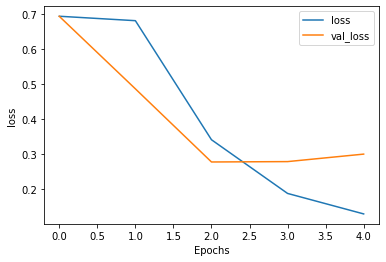

In [16]:
plot_graphs(history, 'loss')

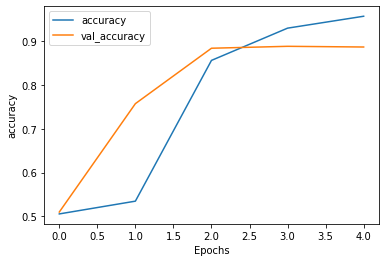

In [17]:
plot_graphs(history, 'accuracy')

## 테스트 데이터 불러오기

In [18]:
DATA_OUT_PATH = './data_out/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'
SAVE_FILE_NM = 'weights.h5'


test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

## 모델 예측

In [20]:
import pandas as pd

predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(test_id), "sentiment":list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_rnn.csv', index=False, quoting=3)

196/196 [==============================] - 3s 14ms/step
